In [1]:
from glob import glob
import cv2
import numpy as np
import itertools as it
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import ndimage, signal, spatial
from skimage import morphology

import os
import pandas as pd

from importlib import reload

import sklearn.linear_model as linear

In [2]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)
unique = np.array([40, 120, 160, 200, 240], dtype=np.uint8)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

rsrc = '../raw/'
src = '../proc/'
time = '4pm'
rep = 7
pidx = 3

asrc = src + 'anchory/' + time + '_rep{}/'.format(rep)
psrc = src + 'prelim/' + time + '_rep{}/plant_{:02d}/'.format(rep,pidx)

filenames = glob(psrc + '*.tif')

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('_')[-1]
    num = int(num)
    nums[i] = num
        
anums = np.argsort(nums)

In [3]:
metafile = '{}{}_rep{}_plant_{:02d}.csv'.format(asrc, time, rep, pidx)
meta = pd.read_csv(metafile, header=None)
meta.index = nums[anums]
print(meta.shape)
meta.head()

(902, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,2752,4896,1144,2945,0,200,0,1144,2131,3737,798,1143,326,857,814,177.127233,0.021208
2,2752,4896,1131,2931,0,200,0,1131,2119,3715,785,1130,325,854,812,176.732974,0.020687
3,2752,4896,1171,2927,0,200,0,1171,2111,3712,792,1154,326,857,816,178.207843,0.017804
4,2752,4896,1124,2924,0,200,0,1124,2114,3716,772,1123,335,855,810,180.539005,0.019273
5,2752,4896,1126,2925,0,200,0,1126,2115,3713,763,1125,340,852,810,177.562033,0.019642


In [4]:
lenraw = meta.iloc[0,0]
tape = meta.iloc[:,2].values
peak = meta.iloc[:,3].values
buffx = meta.iloc[:,4].values
buffy = meta.iloc[:,5].values

plant = meta.iloc[:, 6:10].values.astype(int)
pss = [ np.s_[plant[i,0]:plant[i,1], plant[i,2]:plant[i,3]] for i in range(len(plant)) ]

ceros = meta.iloc[:, 10:14].values.astype(int)
css = [ np.s_[ceros[i, 0]:ceros[i,1], ceros[i,2]:ceros[i,3]] for i in range(len(ceros)) ]
coef = meta.iloc[:,15:].values

rawx = ceros[:, 2] + plant[:, 2] - peak + buffy
rawy = ceros[:, 0] + plant[:, 0] + buffx

xvals = np.arange(lenraw)
b0 = peak + coef[:, 0] - buffy
lines = b0.reshape(-1,1) + np.outer(coef[:,1], xvals)

line = [ lines[i][pss[i][0]] - plant[i,2] for i in range(len(pss)) ]
ll = [ line[i][np.arange(ceros[i,0], ceros[i,1])] - ceros[i,2] for i in range(len(ceros))]
xx = [ np.arange(ceros[i,1] - ceros[i,0]) for i in range(len(ceros)) ]

v0 = np.column_stack((coef[:,1], np.ones(len(coef))))
v = v0/(np.linalg.norm(v0, axis=1)).reshape(-1,1)
n = np.column_stack((-v[:,1], v[:,0]))
p = np.column_stack(([ll[i][0] for i in range(len(ll))], np.zeros(len(ll))))
b = np.sum(p*n, axis=1)

stick = [ np.s_[buffx[i]:tape[i]+buffx[i], peak[i]-buffy[i]:peak[i]+buffy[i]] for i in range(len(tape)) ]

# Specify the timestamp

In [28]:
idx = 301
print(filenames[anums[idx]])
img = tf.imread(filenames[anums[idx]])
skewer = (img == 40) | (img == 160) | (img == 240)
contour = ndimage.grey_erosion(skewer, size=(1,21), mode='constant', cval=255).astype(bool)
img = img*contour
#contour = ndimage.convolve(skewer, boundary, mode='constant')
print(img.shape)

../proc/prelim/4pm_rep7/plant_03/4pm_rep07_0302.tif
(722, 132)


In [29]:
cross = np.asarray(np.nonzero(img > 180))
dist = np.abs(cross[1]*n[idx, 0] + cross[0]*n[idx, 1] - b[idx])
print('Min dist: {:.2f}\nMax dist: {:.2f}'.format(np.min(dist),np.max(dist)))
mask = dist < 10
print(np.sum(mask), np.sum(mask) > 5)

Min dist: 0.11
Max dist: 17.87
176 True


In [30]:
skel = np.zeros(img.shape, dtype=bool)
skel[cross[0, mask], cross[1, mask]] = True
labels,num = ndimage.label(skel, structure=ndimage.generate_binary_structure(2,2))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
where = np.nonzero((hist/np.sum(hist) > 0.1))[0]

print(num,'components\t', len(where), 'preserved')
print(hist, np.round(hist/np.sum(hist), 2))
print('where:\t', where)

if len(where) > 1:
    merged = dict()
    coords = dict()
    for i in range(len(where)):
        coords[where[i]] = np.asarray(np.nonzero(labels == where[i] + 1))
        merged[where[i]] = []

    combs = list(it.combinations(where, 2))
    for i in range(len(combs)):
        dxy = np.min(spatial.distance.cdist(coords[combs[i][0]].T, coords[combs[i][1]].T, metric='euclidean'))
        print(combs[i], dxy, sep='\t')
        
        if dxy < 20:
            merged[combs[i][1]].append(combs[i][0])
    
    print('merge dict:\t', merged)
    
    for j,i in enumerate(where):
        k = i  
        while len(merged[k]) > 0:
            k = min(merged[k])
        print(i, '-->', k, sep='\t')
        labels[labels == i+1] = k+1
        where[j] = k
    
    where = np.unique(where)
    print('where:\t', where)

4 components	 3 preserved
[54  1 72 49] [0.31 0.01 0.41 0.28]
where:	 [0 2 3]
(0, 2)	16.0
(0, 3)	218.21548982599745
(2, 3)	130.01538370516005
merge dict:	 {0: [], 2: [0], 3: []}
0	-->	0
2	-->	0
3	-->	3
where:	 [0 3]


In [31]:
coms = np.asarray(ndimage.center_of_mass(skel, labels, where+1))
coms = coms[(tape[idx] - (coms[:,0] + rawy[idx]))/tape[idx] > 0.1]
print(len(coms))
dmask = []
dcom = []

for i in range(len(coms)):
    com = coms[i]
    dd = np.sqrt(np.sum((cross - com.reshape(-1,1))**2, axis=0))
    dmask.append(dd < 40)
    foo = dd[dmask[i]]
    dcom.append(np.max(foo) + 1 - foo)

2


In [32]:
coefs = np.zeros((len(coms), 2))
angle = np.zeros(len(coms))

for i in range(len(coms)):
    X = cross[1, dmask[i]].reshape(-1,1)
    print(X.shape[1] + 1)
    reg = linear.RANSACRegressor(random_state=3, min_samples=4).fit(X, cross[0,dmask[i]], sample_weight = dcom[i])
    coef1 = np.diff(reg.predict([[0],[1]]))[0]
    coef0 = reg.predict([[0]])[0]
    
    w0 = np.array([1, coef1])
    w = w0/np.linalg.norm(w0)
    
    coefs[i] = [coef0, coef1]
    angle[i] = -np.sign(coef1)*np.arccos(np.abs(np.sum(w*n[idx])))
    
print(np.rad2deg(angle))

2
2
[-78.60858478  67.43288567]


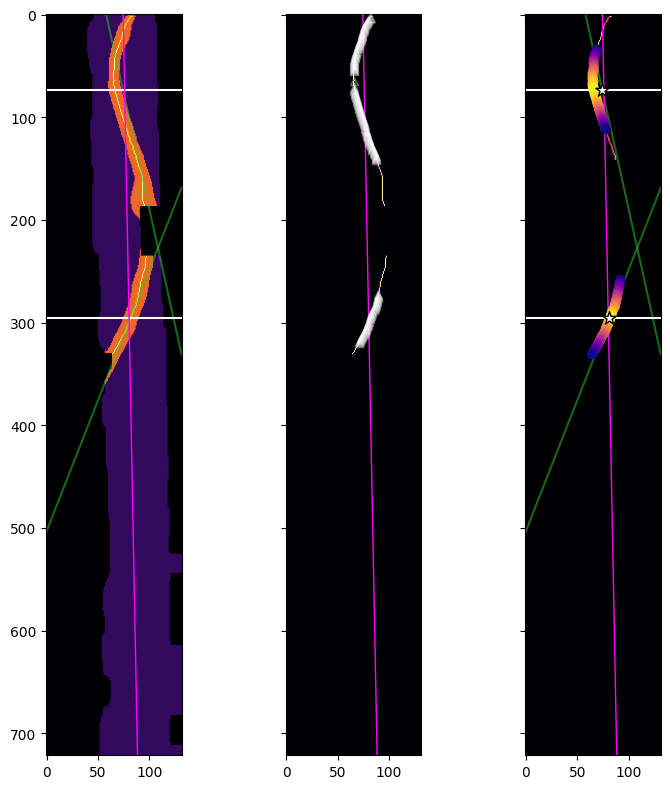

In [33]:
fig, ax = plt.subplots(1,3,figsize=(8,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(img, cmap='inferno', vmin=0, zorder = 2, origin='lower');
#ax[-1].imshow(img*contour, cmap='inferno', vmin=0, zorder = 2, origin='lower');

ax[1].imshow(img > 160, vmin=0, cmap='magma')
ax[1].scatter(cross[1, mask], cross[0, mask], c='w', marker='^', zorder=4, alpha=0.25)

ax[2].imshow(skel, cmap='inferno')
for i in range(len(coms)):
    ax[2].scatter(cross[1, dmask[i]], cross[0, dmask[i]], c=dcom[i], cmap='plasma', zorder=10 - i)
    ax[2].scatter(*np.flip(coms[i]), c='w', s=100, marker='*', zorder=11, edgecolor='k')

#ax[2].scatter(*np.flip(np.mean(coms, axis=0)), c='r', s=100, marker='^', zorder=12, edgecolor='k')

for j in [0,2]:
    for i in range(len(coms)):
        ax[j].axline(xy1 = (coms[i,1], coms[i,0]), slope = coefs[i,1], c='limegreen', alpha=0.5)
        ax[j].axhline(coms[i,0], c='w')

for i in range(len(ax)):
    ax[i].plot(ll[idx],xx[idx], color='magenta', lw=1, zorder=3);

fig.tight_layout()

In [110]:
order = np.argsort(coms[:,0])[::-1]
print(coms[:,0], order)
np.rad2deg(angle[order])

[426.26315789] [0]


array([4.49356746])

In [16]:
rawname = '{}{} Inc Rep {}/{} Inc Rep {} ({}).JPG'.format(rsrc, time, rep, time, rep, nums[anums[idx]])
raw = cv2.imread(rawname)


In [112]:
coefs

array([[ 4.54013087e+02, -9.86264358e-02]])

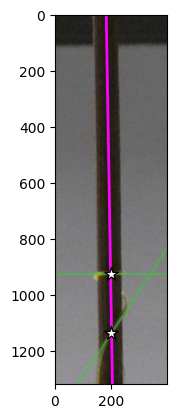

In [17]:
plt.imshow(raw[stick[idx]][:,:,::-1])
plt.plot(lines[idx, stick[idx][0]] - peak[idx] + buffy[idx], xvals[stick[idx][0]] - buffx[idx], c='magenta', lw=2)

plt.scatter(coms[:,1] + rawx[idx] , coms[:,0] + rawy[idx], c='w', s=100, marker='*', zorder=11, edgecolor='k')
for i in range(len(coms)):
    plt.axline(xy1 = (coms[i,1]+rawx[idx], coms[i,0]+rawy[idx]), slope = coefs[i,1], c='limegreen', alpha=0.5)

In [123]:
(tape[idx] - (coms[i,0] + rawy[idx]))/tape[idx]

0.022280701754385936